In [1]:
import heeps
from heeps.util.paralang import paralang
from heeps.util.save2fits import save2fits
from heeps.util.psf_template import psf_template
from vip_hci.metrics import snr, significance
import multiprocessing as mpro
import vip_hci
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
%matplotlib inline

### Initialize parameters

In [2]:
pc = 1.34                   # star distance in parsec
seps = [0.55, 1.1]          # angular separations in AU
cps = [6e-7, 1.5e-7]        # planet contrasts
nhours = 5                  # number of rotation hours
conf = dict(
    mode = 'CVC',
    band = 'N2',
    hfov = 1.3,
    nframes = 12000,        # number of frames to crop the input data
    duration = 3600*nhours, # duration of the ADI sequence in s
    dit = 0.3*nhours,       # detector integration time in s
    dec = -61,              # deg
    mag = -1.6,             # star mag
)
conf = heeps.config.read_config(**conf)
conf = heeps.config.update_config(verbose=True, **conf)

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=1.3 arcsec (-> ndet=383, 20.53 lam/D)



### Parallactic angle

start = 307.79°, end = 52.21°
rotation = 104.42°


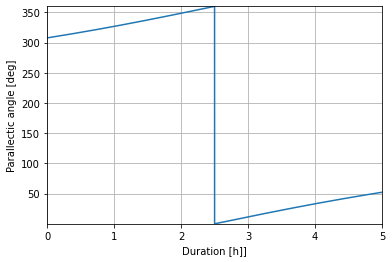

In [3]:
pa = paralang(conf['nframes'], conf['dec'], conf['lat'], conf['duration'])
pa = (pa + 360)%360 
pa_rad = np.deg2rad(pa)
plt.plot(np.arange(len(pa))/len(pa)*nhours, pa)
plt.xlim(0, nhours)
plt.ylim(min(pa), max(pa))
plt.xlabel('Duration [h]]')
plt.ylabel('Parallectic angle [deg]')
plt.grid(True)
print('start = %.2f°, end = %.2f°'%(pa[0], pa[-1]))
print('rotation = %.2f°'%((pa[-1] - pa[0])%360))

### Planet trajectory

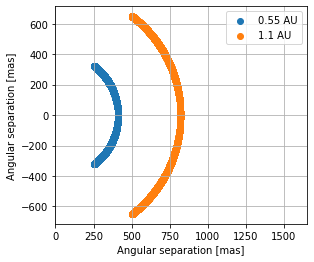

In [4]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/wavefront/point')))
for sep_AU in seps:
    sep = sep_AU/pc*1e3 # mas
    xy = np.array([sep*np.cos(pa_rad), sep*np.sin(pa_rad)]).T
    fits.writeto('point_planet_%sAU_%ss_%sms_%s.fits'%(sep_AU, conf['duration'], 
            int(conf['dit']*1e3), conf['band']), np.float32(-xy), overwrite=True)
    plt.scatter(xy[:,0], xy[:,1], label='%s AU'%sep_AU)
plt.legend()
plt.axis('square')
plt.xlim(left=0)
plt.xlabel('Angular separation [mas]')
plt.ylabel('Angular separation [mas]')
plt.grid(True);

In [5]:
# Note: we save -xy as tip-tilt inputs for HEEPS, so that after FT the negative
# x-axis positions will appear positive. However, the y-axis positions are 
# also flipped, which is equivalent to changing the sign of the parallactic angles.
pa = -pa

# Post-processing

In [6]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/science_case')))

def post_process(conf, method, ncomp=10):
    for case in ['scao_only_5h', 'all_effects_noPSI_noTal_5h']:
        print('case: %s'%case)
        print('-'*5)
        tag = '%s_%s'%(method, ncomp) if 'pca' in method else method
        filename = 'psf_%s_%s_%s_%s.fits'%(tag, conf['band'], conf['mode'], case)
        # load off-axis PSFs
        psf_OFF = fits.getdata('%s/offaxis_PSF_N2_CVC.fits'%case)
        _, fwhm, _ = psf_template(psf_OFF)
        print('fwhm = %.2f px'%fwhm)
        try:
            frame = fits.getdata(filename)
            print('File loaded: ' + filename)
        except FileNotFoundError:
            print('Creating ' + filename)
            # load on-axis PSFs
            psf_ON = fits.getdata('%s/onaxis_PSF_N2_CVC.fits'%case)
            # add planets
            for cp, sep in zip(cps, seps):
                psf_ON += cp*fits.getdata('%s_point_planet_%sAU/onaxis_PSF_N2_CVC.fits'%(case, sep))
            # add background
            psf_ON, _ = heeps.contrast.background(psf_ON, psf_OFF, verbose=True, **conf)
            # run VIP
            if 'adi' in method:
                algo = vip_hci.medsub.median_sub
                frame = algo(psf_ON, pa, nproc=mpro.cpu_count(), full_output=False, verbose=True)
            elif 'pca' in method:
                algo = vip_hci.pca.pca
                frame = algo(psf_ON, pa, ncomp=ncomp, nproc=mpro.cpu_count(), full_output=False, verbose=True)
            fits.writeto(filename, frame, overwrite=True)
        # calculate SNR
        for sep_AU in seps:
            sep = sep_AU/pc*1e3 # mas
            xy = np.array([sep*np.cos(pa_rad), sep*np.sin(pa_rad)]).T
            center = conf['ndet'] // 2
            rad = np.mean(np.sqrt(xy[:,0]**2 + xy[:,1]**2))/conf['pscale']
            source_xy = (center + rad, center)
            print('planet_xy = (%.2f, %.2f)'%source_xy)
            snr_val = snr(frame, source_xy, fwhm, exclude_negative_lobes=False, plot=True, verbose=True)
            sigma = significance(snr_val, rad, fwhm, student_to_gauss=True)
            print('S/N = %.2f, significance = %.2f\n'%(snr_val, sigma))

### median-sub ADI

case: scao_only_5h
-----
fwhm = 8.46 px
File loaded: psf_adi_N2_CVC_scao_only_5h.fits
planet_xy = (251.45, 191.00)
S/N for the given pixel = 11.003
Integrated flux in FWHM test aperture = 25136.795
Mean of background apertures integrated fluxes = -1150.890
Std-dev of background apertures integrated fluxes = 2361.744


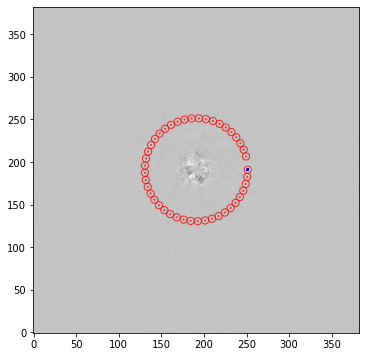

S/N = 11.00, significance = 7.54

planet_xy = (311.90, 191.00)
S/N for the given pixel = 6.966
Integrated flux in FWHM test aperture = 6933.599
Mean of background apertures integrated fluxes = -132.702
Std-dev of background apertures integrated fluxes = 1008.646


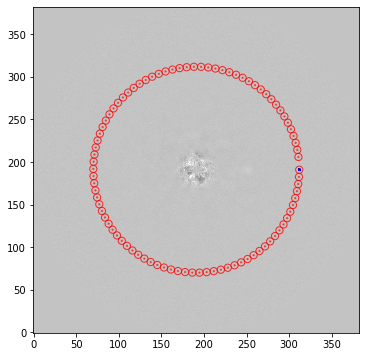

S/N = 6.97, significance = 6.20

case: all_effects_noPSI_noTal_5h
-----
fwhm = 8.57 px
File loaded: psf_adi_N2_CVC_all_effects_noPSI_noTal_5h.fits
planet_xy = (251.45, 191.00)
S/N for the given pixel = 3.025
Integrated flux in FWHM test aperture = 43142.802
Mean of background apertures integrated fluxes = -9888.989
Std-dev of background apertures integrated fluxes = 17328.989


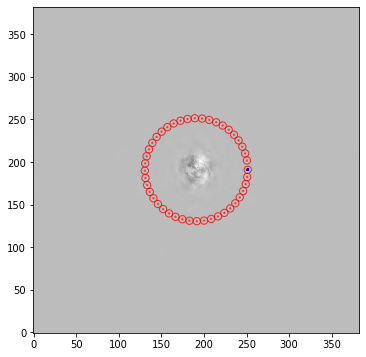

S/N = 3.03, significance = 2.86

planet_xy = (311.90, 191.00)
S/N for the given pixel = 2.766
Integrated flux in FWHM test aperture = 8879.505
Mean of background apertures integrated fluxes = -1415.900
Std-dev of background apertures integrated fluxes = 3701.427


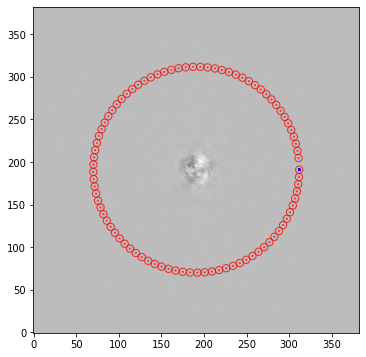

S/N = 2.77, significance = 2.70



In [8]:
post_process(conf, 'adi')

### PCA, 10 comp

case: scao_only_5h
-----
fwhm = 8.46 px
File loaded: psf_pca_10_N2_CVC_scao_only_5h.fits
planet_xy = (251.45, 191.00)
S/N for the given pixel = 9.718
Integrated flux in FWHM test aperture = 14917.084
Mean of background apertures integrated fluxes = -9004.585
Std-dev of background apertures integrated fluxes = 2433.438


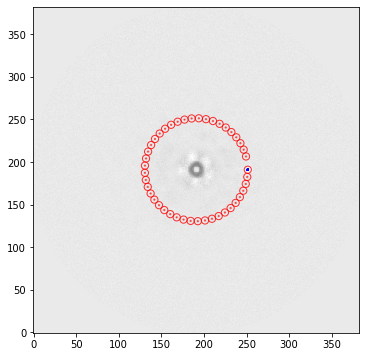

S/N = 9.72, significance = 7.03

planet_xy = (311.90, 191.00)
S/N for the given pixel = 6.951
Integrated flux in FWHM test aperture = 2332.353
Mean of background apertures integrated fluxes = -4593.608
Std-dev of background apertures integrated fluxes = 990.750


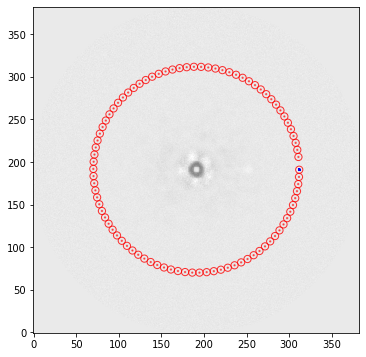

S/N = 6.95, significance = 6.19

case: all_effects_noPSI_noTal_5h
-----
fwhm = 8.57 px
File loaded: psf_pca_10_N2_CVC_all_effects_noPSI_noTal_5h.fits
planet_xy = (251.45, 191.00)
S/N for the given pixel = 0.574
Integrated flux in FWHM test aperture = -177375.867
Mean of background apertures integrated fluxes = -188855.517
Std-dev of background apertures integrated fluxes = 19761.017


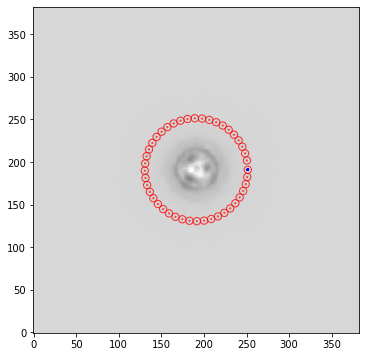

S/N = 0.57, significance = 0.57

planet_xy = (311.90, 191.00)
S/N for the given pixel = 3.579
Integrated flux in FWHM test aperture = 4497.360
Mean of background apertures integrated fluxes = -6546.047
Std-dev of background apertures integrated fluxes = 3068.371


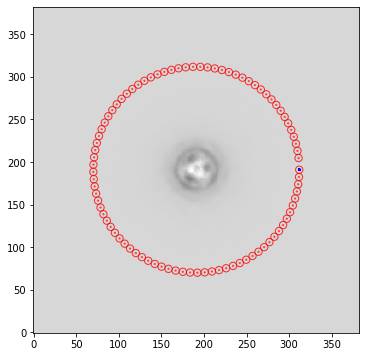

S/N = 3.58, significance = 3.45



In [9]:
post_process(conf, 'pca', ncomp=10)

### PCA, 5 comp

case: scao_only_5h
-----
fwhm = 8.46 px
Creating psf_pca_5_N2_CVC_scao_only_5h.fits
   thruput=0.7473, mask_trans=0.9291,
   mag=-1.6, dit=1.500
   star_signal=2.42e+11, bckg_noise=1.17e+08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-07-29 01:15:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.376 GB
System available memory = 233.301 GB
Done vectorizing the frames. Matrix shape: (12000, 146689)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:51:51.325266
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:55:10.104918
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
planet_xy = (251.45, 191.00)
S/N for the given pixel = 9.663
Integrated flux in FWHM test aperture = 14663.211
Mean of background apertures integrated fluxes = -9154.304
Std-dev of background ap

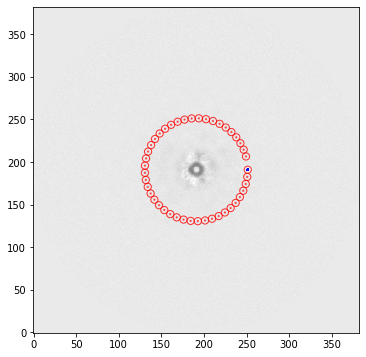

S/N = 9.66, significance = 7.00

planet_xy = (311.90, 191.00)
S/N for the given pixel = 6.979
Integrated flux in FWHM test aperture = 2298.054
Mean of background apertures integrated fluxes = -4584.507
Std-dev of background apertures integrated fluxes = 980.606


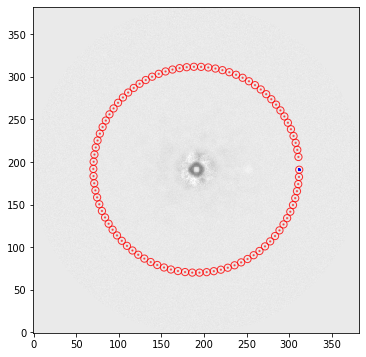

S/N = 6.98, significance = 6.21

case: all_effects_noPSI_noTal_5h
-----
fwhm = 8.57 px
Creating psf_pca_5_N2_CVC_all_effects_noPSI_noTal_5h.fits
   thruput=0.7514, mask_trans=0.9291,
   mag=-1.6, dit=1.500
   star_signal=2.42e+11, bckg_noise=1.17e+08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-07-29 02:13:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.376 GB
System available memory = 233.364 GB
Done vectorizing the frames. Matrix shape: (12000, 146689)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:50:23.431947
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:53:38.178978
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
planet_xy = (251.45, 191.00)
S/N for the given pixel = 1.192
Integrated flux in FWHM test aperture = -226975.236
Mean of background a

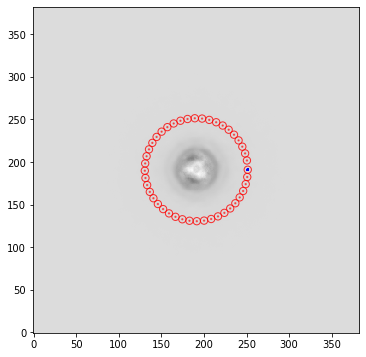

S/N = 1.19, significance = 1.18

planet_xy = (311.90, 191.00)
S/N for the given pixel = 3.091
Integrated flux in FWHM test aperture = 4005.461
Mean of background apertures integrated fluxes = -7798.745
Std-dev of background apertures integrated fluxes = 3797.691


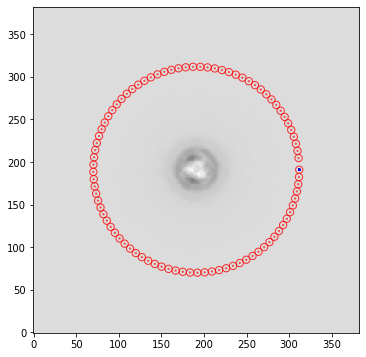

S/N = 3.09, significance = 3.00



In [10]:
post_process(conf, 'pca', ncomp=5)

### PCA, 20 comp

case: scao_only_5h
-----
fwhm = 8.46 px
Creating psf_pca_20_N2_CVC_scao_only_5h.fits
   thruput=0.7473, mask_trans=0.9291,
   mag=-1.6, dit=1.500
   star_signal=2.42e+11, bckg_noise=1.17e+08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-07-29 03:09:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.376 GB
System available memory = 233.688 GB
Done vectorizing the frames. Matrix shape: (12000, 146689)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:50:16.547974
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:53:29.591577
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
planet_xy = (251.45, 191.00)
S/N for the given pixel = 9.450
Integrated flux in FWHM test aperture = 14580.134
Mean of background apertures integrated fluxes = -8988.676
Std-dev of background a

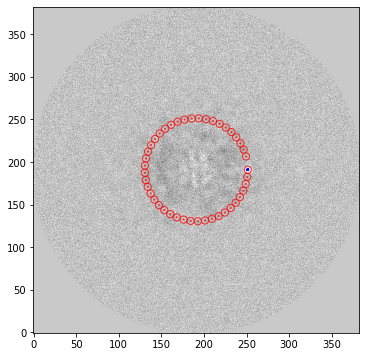

S/N = 9.45, significance = 6.91

planet_xy = (311.90, 191.00)
S/N for the given pixel = 7.096
Integrated flux in FWHM test aperture = 2556.580
Mean of background apertures integrated fluxes = -4575.064
Std-dev of background apertures integrated fluxes = 999.301


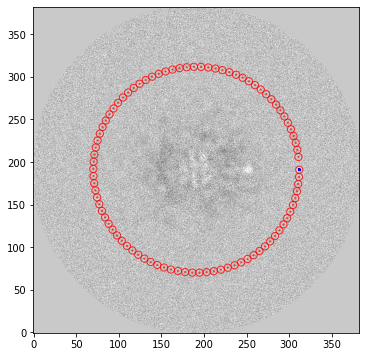

S/N = 7.10, significance = 6.29

case: all_effects_noPSI_noTal_5h
-----
fwhm = 8.57 px
Creating psf_pca_20_N2_CVC_all_effects_noPSI_noTal_5h.fits
   thruput=0.7514, mask_trans=0.9291,
   mag=-1.6, dit=1.500
   star_signal=2.42e+11, bckg_noise=1.17e+08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-07-29 04:05:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 270.376 GB
System available memory = 233.449 GB
Done vectorizing the frames. Matrix shape: (12000, 146689)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:50:19.404746
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:53:34.168786
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
planet_xy = (251.45, 191.00)
S/N for the given pixel = -0.326
Integrated flux in FWHM test aperture = -161776.477
Mean of background

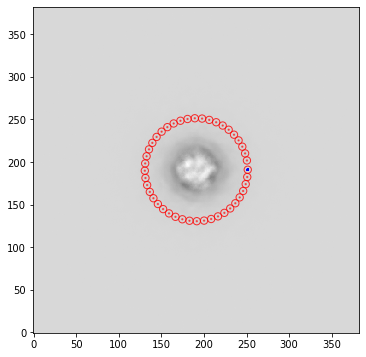

S/N = -0.33, significance = -0.32

planet_xy = (311.90, 191.00)
S/N for the given pixel = 4.475
Integrated flux in FWHM test aperture = 4143.060
Mean of background apertures integrated fluxes = -6462.569
Std-dev of background apertures integrated fluxes = 2356.431


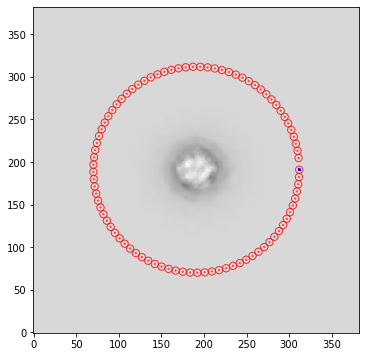

S/N = 4.48, significance = 4.23



In [11]:
post_process(conf, 'pca', ncomp=20)